In [49]:
import nemo
import nemo.collections.asr as nemo_asr
import pytorch_lightning as pl
from omegaconf import DictConfig
import pathlib
import nemo.collections.asr as nemo_asr
import pytorch_lightning as pl
import os
import matplotlib.pyplot as plt
import re

In [2]:
datasets_dir = '../../datasets/'

In [54]:
import pandas as pd
import numpy as np
import fastwer

def calculate_score(dataset, model, model_name='-', k=None, log=True):
    print(f'Calculating score for model {model_name} on {dataset}')
    if dataset == 'LJSpeech':
        metadata = pd.read_csv(datasets_dir + 'LJSpeech-1.1/metadata_test.csv')
        if k is not None:
            metadata = metadata[:k]
        files = metadata['file_name'].apply(lambda x: f'{datasets_dir}/LJSpeech-1.1/wavs/{x}.wav').values
        texts = metadata['transcript'].values
    elif dataset == 'AN4':
        metadata = pd.read_csv(f'{datasets_dir}/an4/metadata.csv')
        files = metadata['file_name'].values
        texts = metadata['transcript'].values
        
    
    wer = []
    cer = []
    predictions = model.transcribe(paths2audio_files=files)
    r = np.random.randint(1, 10)
    print(texts[r])
    print(predictions[r].replace('⁇', ''))
    for i in range(len(predictions)):
        text = texts[i].lower()
        text = re.sub('[^a-zA-Z ]+', '', text)
        prediction = predictions[i]
        prediction = re.sub('[^a-zA-Z ]+', '', prediction)
        wer.append(fastwer.score_sent(text, prediction, char_level=False))
        cer.append(fastwer.score_sent(text, prediction, char_level=True))
    wer = np.array(wer)
    cer = np.array(cer)
    
    wer = wer[wer != float('+inf')]
    cer = cer[cer != float('+inf')]
    
    wer = np.round(np.mean(wer), 2)
    cer = np.round(np.mean(cer), 2)
    if log:
        print(f'wer:{np.round(wer, 2)}; cer:{np.round(cer, 2)}')
    
    return wer, cer

In [4]:
from itertools import zip_longest
from typing import Any, Callable, Dict, List, Optional

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.utilities import rank_zero_info

import copy

class PrintTableMetricsCallback(Callback):
    """Prints a table with the metrics in columns on every epoch end.
    Example::
        from pl_bolts.callbacks import PrintTableMetricsCallback
        callback = PrintTableMetricsCallback()
    Pass into trainer like so:
    .. code-block:: python
        trainer = pl.Trainer(callbacks=[callback])
        trainer.fit(...)
        # ------------------------------
        # at the end of every epoch it will print
        # ------------------------------
        # loss│train_loss│val_loss│epoch
        # ──────────────────────────────
        # 2.2541470527648926│2.2541470527648926│2.2158432006835938│0
    """

    def __init__(self) -> None:
        self.metrics: List = []

    def on_epoch_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        metrics_dict = copy.copy(trainer.callback_metrics)
        self.metrics.append(metrics_dict)
        rank_zero_info(dicts_to_table(self.metrics))
        
def dicts_to_table(
    dicts: List[Dict],
    keys: Optional[List[str]] = None,
    pads: Optional[List[str]] = None,
    fcodes: Optional[List[str]] = None,
    convert_headers: Optional[Dict[str, Callable]] = None,
    header_names: Optional[List[str]] = None,
    skip_none_lines: bool = False,
    replace_values: Optional[Dict[str, Any]] = None,
) -> str:
    """Generate ascii table from dictionary Taken from (https://stackoverflow.com/questions/40056747/print-a-list-
    of-dictionaries-in-table-form)
    Args:
        dicts: input dictionary list; empty lists make keys OR header_names mandatory
        keys: order list of keys to generate columns for; no key/dict-key should
            suffix with '____' else adjust code-suffix
        pads: indicate padding direction and size, eg <10 to right pad alias left-align
        fcodes: formating codes for respective column type, eg .3f
        convert_headers: apply converters(dict) on column keys k, eg timestamps
        header_names: supply for custom column headers instead of keys
        skip_none_lines: skip line if contains None
        replace_values: specify per column keys k a map from seen value to new value;
                        new value must comply with the columns fcode; CAUTION: modifies input (due speed)
    Example:
        >>> a = {'a': 1, 'b': 2}
        >>> b = {'a': 3, 'b': 4}
        >>> print(dicts_to_table([a, b]))
        a│b
        ───
        1│2
        3│4
    """
    # optional arg prelude
    if keys is None:
        if len(dicts) > 0:
            keys = dicts[0].keys()  # type: ignore[assignment]
        elif header_names is not None:
            keys = header_names
        else:
            raise ValueError("keys or header_names mandatory on empty input list")
    if pads is None:
        pads = [""] * len(keys)  # type: ignore[arg-type]
    elif len(pads) != len(keys):  # type: ignore[arg-type]
        raise ValueError(f"bad pad length {len(pads)}, expected: {len(keys)}")  # type: ignore[arg-type]
    if fcodes is None:
        fcodes = [""] * len(keys)  # type: ignore[arg-type]
    elif len(fcodes) != len(fcodes):
        raise ValueError(f"bad fcodes length {len(fcodes)}, expected: {len(keys)}")  # type: ignore[arg-type]
    if convert_headers is None:
        convert_headers = {}
    if header_names is None:
        header_names = keys
    if replace_values is None:
        replace_values = {}
    # build header
    headline = "│".join(f"{v:{pad}}" for v, pad in zip_longest(header_names, pads))  # type: ignore[arg-type]
    underline = "─" * len(headline)
    # suffix special keys to apply converters to later on
    marked_keys = [h + "____" if h in convert_headers else h for h in keys]  # type: ignore[union-attr]
    marked_values = {}
    s = "│".join(f"{{{h}:{pad}{fcode}}}" for h, pad, fcode in zip_longest(marked_keys, pads, fcodes))
    lines = [headline, underline]
    for d in dicts:
        none_keys = [k for k, v in d.items() if v is None]
        if skip_none_lines and none_keys:
            continue
        elif replace_values:
            for k in d.keys():
                if k in replace_values and d[k] in replace_values[k]:
                    d[k] = replace_values[k][d[k]]
                if d[k] is None:
                    raise ValueError(f"bad or no mapping for key '{k}' is None. Use skip or change replace mapping.")
        elif none_keys:
            raise ValueError(f"keys {none_keys} are None in {d}. Do skip or use replace mapping.")
        for h in convert_headers:
            if h in keys:  # type: ignore[operator]
                converter = convert_headers[h]
                marked_values[h + "____"] = converter(d)
        line = s.format(**d, **marked_values)
        lines.append(line)
    return "\n".join(lines)

In [5]:
try:
    from ruamel.yaml import YAML
except ModuleNotFoundError:
    from ruamel_yaml import YAML

config_path = 'stt_en_citrinet_256_gamma_0_25'
config_name = 'model_config.yaml'
yaml = YAML(typ='safe')

with open(os.path.join(config_path, config_name)) as f:
    config = yaml.load(f)

In [6]:
config['tokenizer']['dir'] = 'citrinet_tokenizer/tokenizer_spe_unigram_v1024'
config['tokenizer']['type'] = 'bpe'

config['train_ds']['manifest_filepath']="../../datasets/LJSpeech-1.1/train_manifest.json"
config['train_ds']['batch_size'] = 8
config['train_ds']['num_workers'] = 12
config['train_ds']['pin_memory'] = True

config['validation_ds']['manifest_filepath']="../../datasets/LJSpeech-1.1/test_manifest.json"
config['validation_ds']['batch_size'] = 8
config['validation_ds']['num_workers'] = 12
config['validation_ds']['pin_memory'] = True

config['spec_augment']['freq_masks'] = 0
config['spec_augment']['time_masks'] = 0
config['optim']['lr'] = 0.01
config['optim']['name'] = 'novograd'
config['optim']['betas'] = [0.8, 0.25]
config['optim']['weight_decay'] = 0.001
config['optim']['sched']['warmup_steps']=1000
config['optim']['sched']['min_lr'] = 0.00001

config['tokenizer']['model_path'] = 'stt_en_citrinet_256_gamma_0_25/3d20ebb793c84a64a20c7ad26fc64d62_tokenizer.model'
config['tokenizer']['vocab_path'] = 'stt_en_citrinet_256_gamma_0_25/df5191f216004f10a268c44e90fdb63f_vocab.txt'
config['tokenizer']['spe_tokenizer_vocab'] = 'stt_en_citrinet_256_gamma_0_25/b774eaac83804907843607272fde21a4_tokenizer.vocab'

In [7]:
callback = PrintTableMetricsCallback()

trainer = pl.Trainer(gpus=1, max_epochs=50,\
                     callbacks=[callback], check_val_every_n_epoch=1, precision=32, sync_batchnorm=False,\
                     benchmark=False
                    )

model_name = 'stt_en_citrinet_256_gamma_0_25'

decoder_ckpt_copy = checkpoint.decoder.state_dict()

# Load finetuning model
asr_model = nemo_asr.models.EncDecCTCModelBPE(cfg=DictConfig(config), trainer=trainer)


# Train model
trainer.fit(asr_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


[NeMo I 2021-10-27 15:15:43 cloud:56] Found existing object /home/boris/.cache/torch/NeMo/NeMo_1.4.0/stt_en_citrinet_256_gamma_0_25/d6eff3868f2f7a4791eb935c8366fc46/stt_en_citrinet_256_gamma_0_25.nemo.
[NeMo I 2021-10-27 15:15:43 cloud:62] Re-using file from: /home/boris/.cache/torch/NeMo/NeMo_1.4.0/stt_en_citrinet_256_gamma_0_25/d6eff3868f2f7a4791eb935c8366fc46/stt_en_citrinet_256_gamma_0_25.nemo
[NeMo I 2021-10-27 15:15:43 common:702] Instantiating model from pre-trained checkpoint
[NeMo I 2021-10-27 15:15:43 mixins:149] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2021-10-27 15:15:44 modelPT:131] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    trim_silence: false
    max_duration: 20.0
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    use_start_end_token: false
    
[NeMo W 2021-10-27 15:15:44 modelPT:138] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 16000
    batch_size: 32
    shuffle: false
    use_start_end_token: false
    
[NeMo W 2021-10-27 15:15:44 modelPT:144] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a v

[NeMo I 2021-10-27 15:15:44 features:262] PADDING: 16
[NeMo I 2021-10-27 15:15:44 features:279] STFT using torch
[NeMo I 2021-10-27 15:15:47 save_restore_connector:143] Model EncDecCTCModelBPE was successfully restored from /home/boris/.cache/torch/NeMo/NeMo_1.4.0/stt_en_citrinet_256_gamma_0_25/d6eff3868f2f7a4791eb935c8366fc46/stt_en_citrinet_256_gamma_0_25.nemo.
[NeMo I 2021-10-27 15:15:47 mixins:149] Tokenizer SentencePieceTokenizer initialized with 1024 tokens
[NeMo I 2021-10-27 15:15:48 collections:173] Dataset loaded with 10480 files totalling 19.11 hours
[NeMo I 2021-10-27 15:15:48 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2021-10-27 15:15:48 collections:173] Dataset loaded with 2620 files totalling 4.81 hours
[NeMo I 2021-10-27 15:15:48 collections:174] 0 files were filtered totalling 0.00 hours


[NeMo W 2021-10-27 15:15:48 ctc_bpe_models:235] Could not load dataset as `manifest_filepath` was None. Provided config : {'manifest_filepath': None, 'sample_rate': 16000, 'batch_size': 4, 'shuffle': False, 'use_start_end_token': False}


[NeMo I 2021-10-27 15:15:48 features:262] PADDING: 16
[NeMo I 2021-10-27 15:15:48 features:279] STFT using torch


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2021-10-27 15:15:49 modelPT:544] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.25]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2021-10-27 15:15:49 lr_scheduler:625] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f9478a73fd0>" 
    will be used during training (effective maximum steps = 65500) - 
    Parameters : 
    (warmup_steps: 1000
    warmup_ratio: null
    min_lr: 1.0e-05
    last_epoch: -1
    max_steps: 65500
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 9.1 M 
2 | decoder           | ConvASRDecoder                    | 657 K 
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WERBPE                            | 0     
------------------------------------------------------------------------
9.8 M     Trainable params
0         Non-trainable params
9.8 M     Total params
39.145    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[NeMo W 2021-10-27 15:15:52 patch_utils:50] torch.stft() signature has been updated for PyTorch 1.7+
    Please update PyTorch to remain compatible with later versions of NeMo.
[NeMo W 2021-10-27 15:15:52 nemo_logging:349] /home/boris/anaconda3/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
      normalized, onesided, return_complex)
    
val_loss│val_wer
────────────────
482.0693054199219│1.0


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568


Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258


Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839


Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888


Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257


Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596


Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596


Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257


Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888


Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.937124013900

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
val_loss│val_w

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

val_loss│val_wer
────────────────
482.0693054199219│1.0
259.70184326171875│0.9371240139007568
259.70184326171875│0.9371240139007568
179.81761169433594│0.9167146682739258
179.81761169433594│0.9167146682739258
161.4345703125│0.8555659055709839
161.4345703125│0.8555659055709839
127.43437194824219│0.7352935075759888
127.43437194824219│0.7352935075759888
97.29762268066406│0.6542714834213257
97.29762268066406│0.6542714834213257
77.14606475830078│0.5542099475860596
77.14606475830078│0.5542099475860596
66.05048370361328│0.5259782671928406
66.05048370361328│0.5259782671928406
55.86479949951172│0.4548432528972626
55.86479949951172│0.4548432528972626
53.819862365722656│0.4549028277397156
53.819862365722656│0.4549028277397156
46.519744873046875│0.4040183424949646
46.519744873046875│0.4040183424949646
43.71575164794922│0.3954813480377197
43.71575164794922│0.3954813480377197
41.6699333190918│0.37398001551628113
41.6699333190918│0.37398001551628113
39.740360260009766│0.3623061776161194
39.74036026000

Validating: 0it [00:00, ?it/s]

[NeMo W 2021-10-27 19:13:08 nemo_logging:349] /home/boris/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1051: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
      rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
    


In [28]:
results = pd.DataFrame.from_dict(callback.metrics)
results.head()

,val_loss,val_wer,train_loss,learning_rate,training_batch_wer
0,"tensor(482.0693, device='cuda:0')","tensor(1., device='cuda:0')",NaN,NaN,NaN
1,"tensor(259.7018, device='cuda:0')","tensor(0.9371, device='cuda:0')","tensor(185.1607, device='cuda:0')","tensor(0.0100, device='cuda:0')","tensor(0.9315, device='cuda:0')"
2,"tensor(259.7018, device='cuda:0')","tensor(0.9371, device='cuda:0')","tensor(185.1607, device='cuda:0')","tensor(0.0100, device='cuda:0')","tensor(0.9315, device='cuda:0')"
3,"tensor(179.8176, device='cuda:0')","tensor(0.9167, device='cuda:0')","tensor(193.4684, device='cuda:0')","tensor(0.0100, device='cuda:0')","tensor(0.9404, device='cuda:0')"
4,"tensor(179.8176, device='cuda:0')","tensor(0.9167, device='cuda:0')","tensor(193.4684, device='cuda:0')","tensor(0.0100, device='cuda:0')","tensor(0.9404, device='cuda:0')"


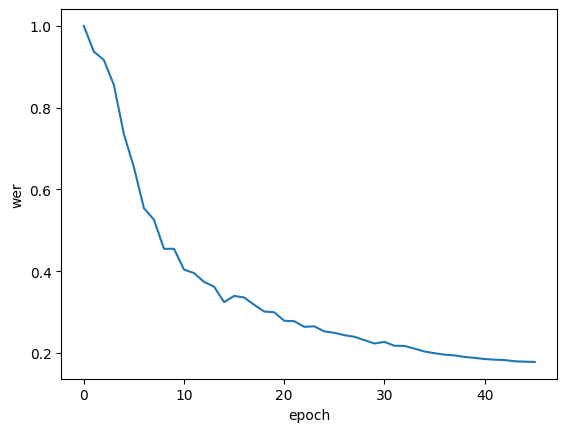

In [36]:
plt.plot(results['val_wer'].values[::2])

# plt.title('val WER')
plt.xlabel('epoch')
plt.ylabel('wer')

plt.show()

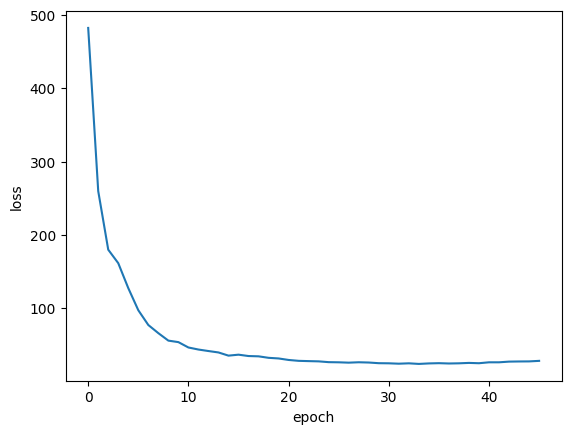

In [42]:
plt.plot(results['val_loss'].values[::2])

# plt.title('val WER')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

In [61]:
calculate_score('LJSpeech', asr_model, 'citrinet_256', k=10)
calculate_score('AN4', asr_model, 'citrinet_256', k=100)

Calculating score for model citrinet_256 on LJSpeech


Transcribing:   0%|          | 0/3 [00:00<?, ?it/s]

brewer met mcdonald and the other policemen at the alley exit door,
brewer met mcdonald and the other policemen at the all exite door 
wer:19.74; cer:7.57
Calculating score for model citrinet_256 on AN4


Transcribing:   0%|          | 0/33 [00:00<?, ?it/s]

rubout n i m n one
gambt  anumch i and aed aud 
wer:97.66; cer:75.05


(97.66, 75.05)

In [58]:
asr_model.save_to("stt_en_citrinet_256_gamma_0_25_LJSpeech.nemo")